In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/lib/python3/dist-packages/matplotlib/__init__.py:760: UserWarning: Found matplotlib configuration in ~/.matplotlib/. To conform with the XDG base directory standard, this configuration location has been deprecated on Linux, and the new location is now '/home/ngaravito/.config'/matplotlib/. Please move your configuration there to ensure that matplotlib will continue to find it in the future.
  _get_xdg_config_dir())


In [132]:
N = 10000

In [133]:
def random_SN(N):
    r_max = 2000.
    r = np.random.random(N)
    cos_theta = np.random.random(N)*2.0-1.0
    phi = np.random.random(N)*2*pi
    theta = np.arccos(cos_theta)
    x = r**(1/2.0)*sin(theta)*cos(phi)*r_max
    y = r**(1/2.0)*sin(theta)*sin(phi)*r_max
    z = r**(1/2.0)*cos(theta)*r_max
    return x, y, z

In [134]:
xsn, ysn, zsn = random_SN(N)

(-3000.0, 3000.0, -3000.0, 3000.0)

/usr/lib/python3/dist-packages/matplotlib/collections.py:549: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


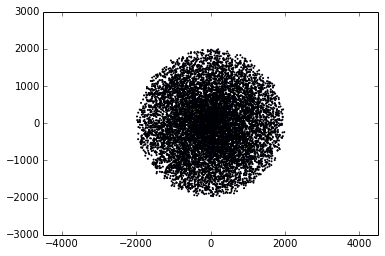

In [135]:
scatter(xsn, ysn, s=1)
axis('equal')

In [136]:
r = np.sqrt(xsn**2.0+ysn**2.0+zsn**2.0)

In [137]:
mean(r)

1332.3591468367613

In [138]:
2000**3.0/3.0 / 2E6

1333.3333333333333

#2.

In [139]:
Mag = np.random.normal(-19, 1, N)

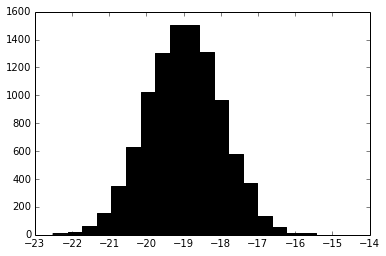

In [140]:
hmag = hist(Mag, color='k', bins=20)

In [167]:
def aparent_magnitudes(M, xyz):
    d = np.sqrt(xyz[:,0]**2.0+xyz[:,1]**2.0+xyz[:,2]**2.0)
    m = 5*log10(d) - 5 + M
    index  = np.where(m<=20)[0]
    return m[index], xyz[index]

In [168]:
m, xyz_mcut = aparent_magnitudes(Mag, np.array([xsn, ysn, zsn]).T) 

In [169]:
len(m)

10000

In [170]:
print(Mag, m)

[-19.27247847 -19.02959442 -18.9765774  ..., -20.73216115 -17.77500242
 -18.86839382] [-9.2517739  -7.85669881 -8.2640756  ..., -9.78216689 -6.48134019
 -7.43379878]


In [183]:
d = np.sqrt(xsn**2.0+ysn**2.0+zsn**2.0)
v = d*72 # in km/s
d_obs = 10**((m+19+5)/5.0)

/usr/lib/python3/dist-packages/matplotlib/collections.py:549: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


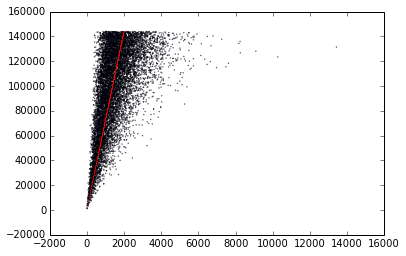

In [187]:
scatter(d_obs, v, s=0.1)
scatter(d, v, s=0.1, c='r', edgecolor='none')

In [188]:
Hobs = np.mean(v/d_obs)
print(Hobs)

79.8939375073


In [ ]:
#2.

In [191]:
data = np.loadtxt('../../Instrumentation/HW2.txt')
X = data[:,1]
Y = data[:,2]
sigma_y = data[:,3]

In [234]:
def likelihood(m, b, V, P, Yb):
    if ((P<0) & (P>=1)):
        L=0
    else:
        exp1 = (1-P)/(np.sqrt(2.*np.pi*sigma_y**2.0))*np.exp(-(Y-(m*X)-b)**2.0/(2.0*sigma_y**2.0))
        exp2 = P/(np.sqrt(2.0*np.pi*(sigma_y**2.0+V)))*np.exp(-(Y-Yb)**2.0/(2.0*(sigma_y**2.0+V)))
        L = np.prod(exp1+exp2)
    
    return L

In [235]:
def MCMC_ND(N_points, sigma_m, sigma_b, sigma_V, sigma_P, sigma_Y):
    L = np.zeros(N_points)
    m_walk= np.zeros(N_points)
    b_walk = np.zeros(N_points)
    V_walk = np.zeros(N_points)
    P_walk = np.zeros(N_points)
    Y_walk = np.zeros(N_points)

    acpt = 0
    m_walk[0] = 1.0
    b_walk[0] = 33
    V_walk[0] = 2000.
    P_walk[0] = 0.5
    Y_walk[0] = 350.
    
    L[0] = likelihood(m_walk[0], b_walk[0], V_walk[0], P_walk[0], Y_walk[0])

    for i in range(1,N_points):
        m_new = np.random.normal(m_walk[i-1], sigma_m)
        b_new = np.random.normal(b_walk[i-1], sigma_b)
        V_new = np.random.normal(V_walk[i-1], sigma_V)
        P_new = np.random.normal(P_walk[i-1], sigma_P)
        Y_new = np.random.normal(Y_walk[i-1], sigma_Y)

        L_new = likelihood(m_new, b_new, V_new, P_new, Y_new)
        R = L_new/L[i-1]
        if R>=1.0:
            m_walk[i] = m_new
            b_walk[i] = b_new
            V_walk[i] = V_new
            P_walk[i] = P_new
            Y_walk[i] = Y_new
            L[i] = likelihood(m_new, b_new, V_new, P_new, Y_new)
            acpt +=1          

        else:
            P = random.random(1)
            if P < R:
                m_walk[i] = m_new
                b_walk[i] = b_new
                V_walk[i] = V_new
                P_walk[i] = P_new
                Y_walk[i] = Y_new
                L[i] = likelihood(m_new, b_new, V_new, P_new, Y_new)
                acpt +=1
            else:
                m_walk[i] = m_walk[i-1]
                b_walk[i] = b_walk[i-1]
                V_walk[i] = V_walk[i-1]
                P_walk[i] = P_walk[i-1]
                Y_walk[i] = Y_walk[i-1]
                L[i] = L[i-1]
    return m_walk, b_walk, V_walk, P_walk, Y_walk, acpt

In [236]:
m_test, b_test, V_test, P_test, Y_test, acpt = MCMC_ND(100000, 0.1, 1, 100, 0.05, 50)

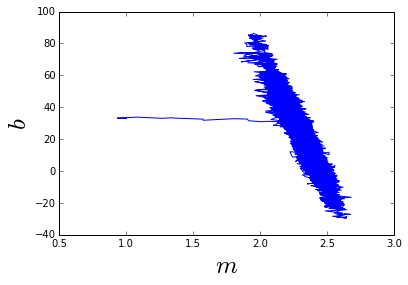

In [237]:
plot(m_test, b_test)
xlabel('$m$', fontsize=25)
ylabel('$b$', fontsize=25)

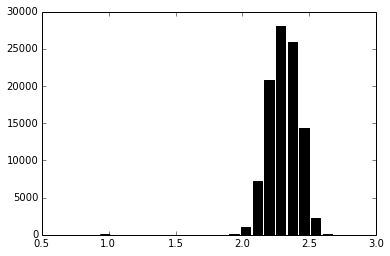

In [238]:
hm = hist(m_test, bins=20, color='k', rwidth=0.8)


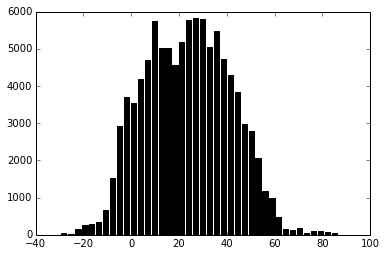

In [239]:
hb = hist(b_test, bins=40, color='k', rwidth=0.75)

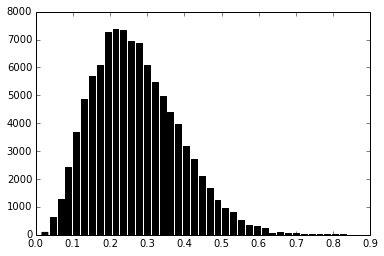

In [240]:
hP = hist(P_test, bins=40, color='k', rwidth=0.75)

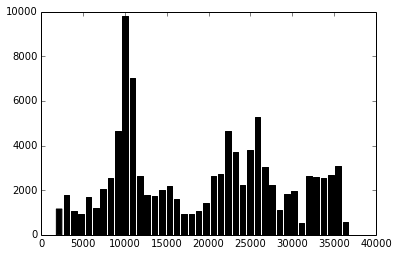

In [242]:
hV = hist(V_test, bins=40, color='k', rwidth=0.75)

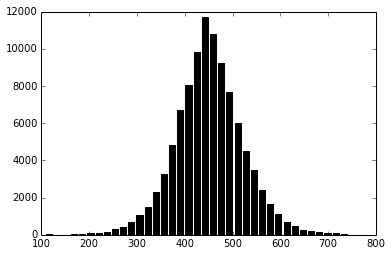

In [243]:
hY = hist(Y_test, bins=40, color='k', rwidth=0.75)